C:\Users\chenz\AppData\Local\Temp\ipykernel_37616\300873695.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
c:\Users\chenz\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
c:\Users\chenz\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


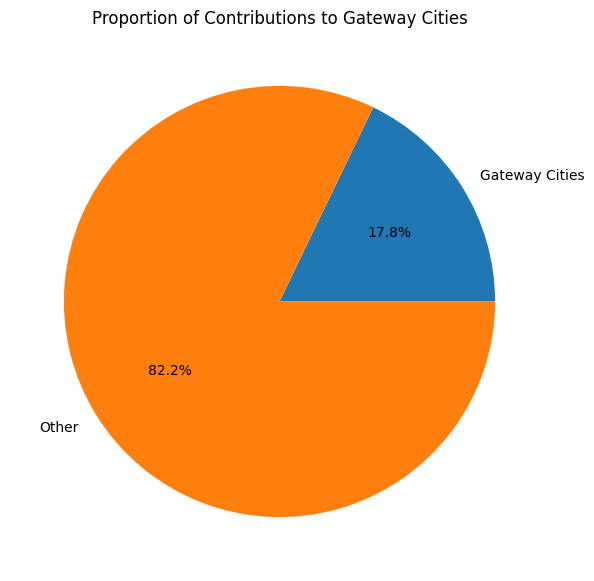

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the datasets
df_base_bundle = pd.read_excel('BU_Spark_20240117.xlsx', sheet_name='Base_bundle')
df_grants = pd.read_excel('BU_Spark_20240117.xlsx', sheet_name='Grants')
df_organizations = pd.read_excel('Demographics flat file_202401.xlsx', sheet_name='Organizations')

# Define your list of Gateway Cities - replace with actual Gateway Cities
gateway_cities = ['Attleboro', 'Barnstable', 'Brockton', 'Chelsea', 'Chicopee', 'Everett', 'Fall River',
                  'Fitchburg', 'Haverhill', 'Holyoke', 'Lawrence', 'Leominster', 'Lowell', 'Lynn', 'Malden',
                  'Methuen', 'New Bedford', 'Peabody', 'Pittsfield', 'Quincy', 'Revere', 'Salem', 'Springfield',
                  'Taunton', 'Westfield', 'Worcester']

# Question 1: Proportion of contributions made to organizations in Gateway Cities
df_grants['Gateway_City'] = df_grants['recip_city'].isin(gateway_cities)
gateway_contributions = df_grants[df_grants['Gateway_City']]['amount_usd'].sum()
total_contributions = df_grants['amount_usd'].sum()
proportion_gateway_contributions = gateway_contributions / total_contributions

# Visualize the proportion of contributions to Gateway Cities
plt.figure(figsize=(10, 7))
plt.pie([proportion_gateway_contributions, 1 - proportion_gateway_contributions], 
        labels=['Gateway Cities', 'Other'], autopct='%1.1f%%')
plt.title('Proportion of Contributions to Gateway Cities')
plt.show()

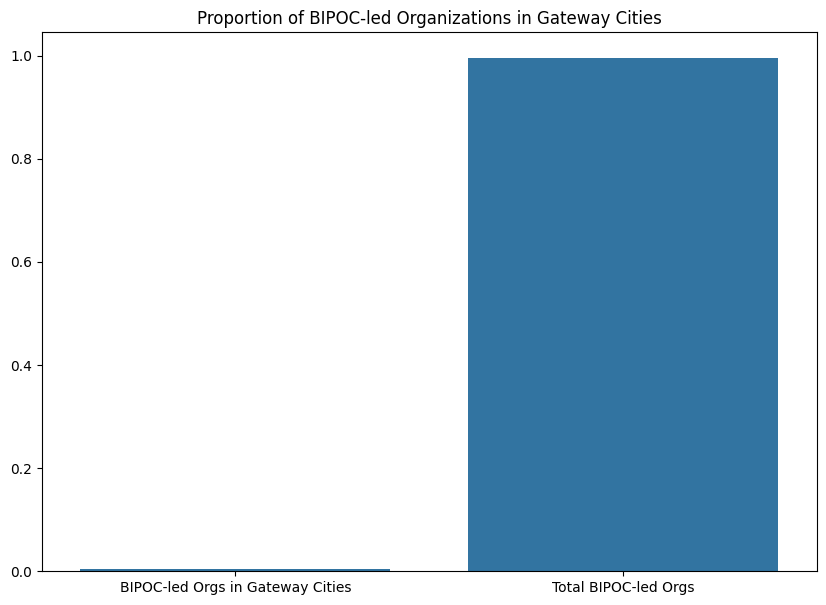

In [2]:
# Question 2: Proportion of BIPOC-led organizations in Gateway Cities
df_organizations['Gateway_City'] = df_organizations['city'].isin(gateway_cities)
bi_poc_led = df_organizations[(df_organizations['race_leader'].isin(['Black/African American', 'Hispanic/Latino/Latina/Latinx']))]
proportion_bi_poc_led_gateway = bi_poc_led['Gateway_City'].mean()

# Visualize the proportion of BIPOC-led organizations in Gateway Cities
plt.figure(figsize=(10, 7))
sns.barplot(x=['BIPOC-led Orgs in Gateway Cities', 'Total BIPOC-led Orgs'], 
            y=[proportion_bi_poc_led_gateway, 1 - proportion_bi_poc_led_gateway])
plt.title('Proportion of BIPOC-led Organizations in Gateway Cities')
plt.show()

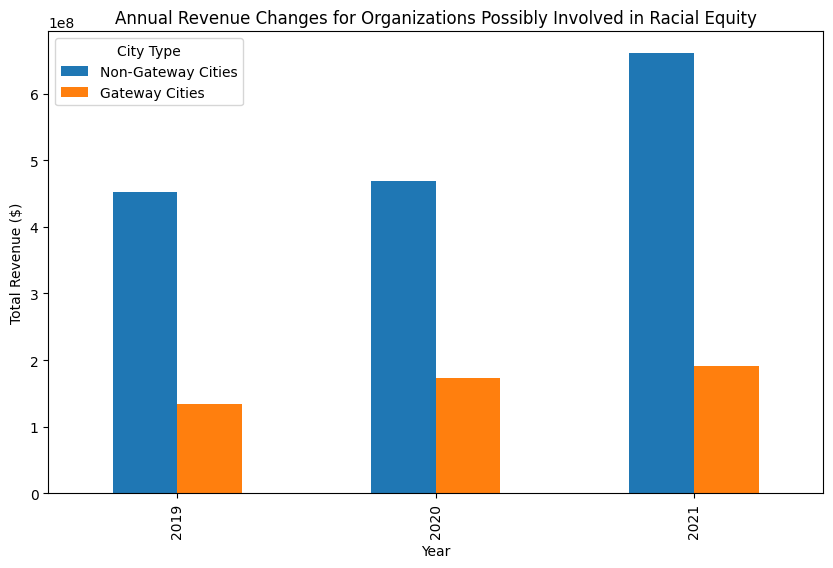

In [3]:
# Question 3: Revenue changes of racial equity/justice organizations in Gateway Cities vs other parts

# Merge the data as needed, or make sure it is loaded correctly with all necessary columns
# Example of merging, adjust according to your actual datasets and keys
# Rename the first column in df_organizations if it's used as 'ein'
df_organizations.rename(columns={'Unnamed: 0': 'ein'}, inplace=True)

# Convert city column to title case in both DataFrames before merging
df_base_bundle['city'] = df_base_bundle['city'].str.title()
df_organizations['city'] = df_organizations['city'].str.title()

# Merge on 'ein' and ensure cities align
merged_data = pd.merge(df_base_bundle, df_organizations, on=['ein', 'city'], how='inner')

# Create the 'year' column from 'period_end' which should be a date column in one of your dataframes
merged_data['year'] = pd.to_datetime(merged_data['period_end']).dt.year

# Verify the presence of 'city' column after merging
if 'city' not in merged_data.columns:
    print("Error: 'city' column is missing after merging.")
    exit()  # Exit or handle the error as needed

# Define 'Is_Gateway' based on the city
merged_data['Is_Gateway'] = merged_data['city'].isin(gateway_cities)

# Define broader categories that might include racial equity or justice initiatives
inclusive_keywords = r"Community Foundations|Human Service Organizations|Cultural, Ethnic Awareness"

# Update the filtering to include these broader categories
racial_equity_orgs = merged_data[merged_data['ntee_description'].str.contains(inclusive_keywords, na=False, regex=True)]

if racial_equity_orgs.empty:
    print("No organizations found under broader categories.")
else:
    # Proceed with the grouping and plotting
    annual_revenue = racial_equity_orgs.groupby(['year', 'Is_Gateway'])['total_revenue'].sum().unstack().fillna(0)
    annual_revenue.plot(kind='bar', figsize=(10, 6))
    plt.title('Annual Revenue Changes for Organizations Possibly Involved in Racial Equity')
    plt.xlabel('Year')
    plt.ylabel('Total Revenue ($)')
    plt.legend(['Non-Gateway Cities', 'Gateway Cities'], title='City Type')
    plt.show()

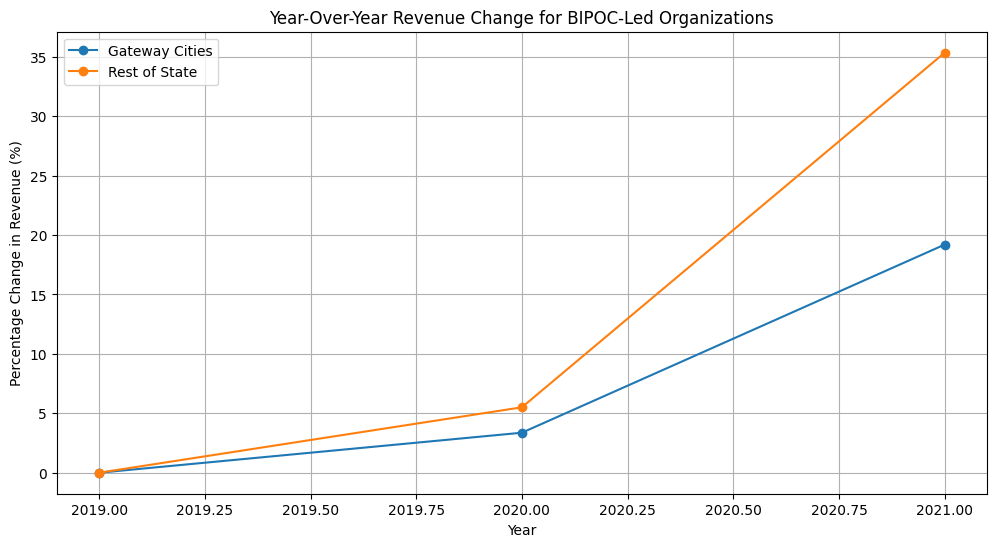

In [14]:
# Filter for BIPOC-led organizations
bipoc_led_orgs = merged_data[merged_data['race_leader'].isin(['Black/African American', 'Hispanic/Latino', 'Asian/Pacific Islander', 'Native American'])]

# Separate data into Gateway Cities and non-Gateway Cities
gateway_bipoc = bipoc_led_orgs[bipoc_led_orgs['Is_Gateway']]
non_gateway_bipoc = bipoc_led_orgs[~bipoc_led_orgs['Is_Gateway']]

# Calculate total revenue by year for each group
gateway_revenue = gateway_bipoc.groupby('year')['total_revenue'].sum()
non_gateway_revenue = non_gateway_bipoc.groupby('year')['total_revenue'].sum()

# Calculate year-over-year percentage change in revenue
gateway_revenue_change = gateway_revenue.pct_change() * 100  # Keep NaN which will be handled later
non_gateway_revenue_change = non_gateway_revenue.pct_change() * 100  # Keep NaN which will be handled later

# Fill NaN with 0 for the baseline year (2019) to indicate no previous year for comparison
gateway_revenue_change.fillna(0, inplace=True)
non_gateway_revenue_change.fillna(0, inplace=True)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(gateway_revenue_change.index, gateway_revenue_change.values, label='Gateway Cities', marker='o')
plt.plot(non_gateway_revenue_change.index, non_gateway_revenue_change.values, label='Rest of State', marker='o')
plt.title('Year-Over-Year Revenue Change for BIPOC-Led Organizations')
plt.xlabel('Year')
plt.ylabel('Percentage Change in Revenue (%)')
plt.legend()
plt.grid(True)
plt.show()